# Conditional Language Model with Attention (5.1)


*   STEP 1 TOKENIZE THE DATA
*   STEP 2 PREPROCESS INTO SMALLER SEQUENCES FOR TRAINING
*   STEP 3 TRAIN ATTENTION MODEL - WITH CONDITION
*   STEP 4 EVALUATE RESULTS (BLEU & UNIVERSAL COSINE SIMILARITY)



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 0 // IMPORT OUR STUFF

In [ ]:
# !pip install numpy
import pandas as pd
import numpy as np
import ast
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import compress

import random
import sys
import io

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Masking, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dot, Permute
from tensorflow.keras.layers import Conv1D, Activation, Multiply, Flatten, BatchNormalization, Add
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax
from tensorflow.keras import activations

from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
data = pd.read_csv('/content/drive/My Drive/CS230/finaldata.csv')
train = pd.read_csv('/content/drive/My Drive/CS230/finaldata_train.csv')
test = pd.read_csv('/content/drive/My Drive/CS230/finaldata_test.csv')

In [ ]:
pd.set_option('display.max_colwidth', -1)
data.head(5).iloc[:, :3]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,genres,overview,title
0,"['animation', 'comedy', 'family']","Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",Toy Story
1,"['adventure', 'fantasy', 'family']","When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",Jumanji
2,"['romance', 'comedy']","A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",Grumpier Old Men
3,['comedy'],"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",Father of the Bride Part II
4,"['action', 'crime', 'drama', 'thriller']","Obsessive master thief, Neil McCauley leads a top-notch crew on various insane heists throughout Los Angeles while a mentally unstable detective, Vincent Hanna pursues him without rest. Each man recognizes and respects the ability and the dedication of the other even though they are aware their cat-and-mouse game may end in violence.",Heat


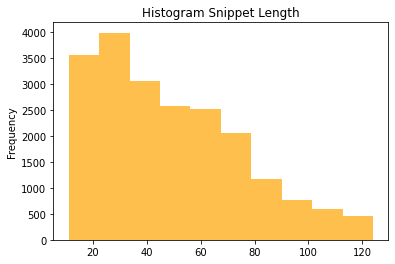

Average Snippet is:  48  words.


In [ ]:
# Reminder of the length of the snippets...
data['length'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Histogram Snippet Length')

plt.show()

print('Average Snippet is: ', int(np.mean(data.length)), ' words.')

## STEP1 // LET'S TOKENIZE THE DATA

In [ ]:
data['overview_stop']=['<START> '+a+' <END>' for a in data.overview_stop]
train['overview_stop']=['<START> '+a+' <END>' for a in train.overview_stop]
test['overview_stop']=['<START> '+a+' <END>' for a in test.overview_stop]

In [ ]:
# Tokenizing / Create a Tokenizer object

liststrings = list(data.overview_stop)
size_dict = 10000
tokenizer = Tokenizer(num_words= size_dict+1, 
                      filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n', 
                      split=' ', 
                      oov_token='<UNK>',
                      document_count=0)


tokenizer.fit_on_texts(liststrings) 
seqtokens = tokenizer.texts_to_sequences(liststrings)
traintokens = tokenizer.texts_to_sequences(list(train.overview_stop))
testtokens = tokenizer.texts_to_sequences(list(test.overview_stop))

tokenizer_config = tokenizer.get_config()
dict_counts = tokenizer_config['word_counts']
dict_index = tokenizer_config['word_index'] 

In [ ]:
tokenizer.sequences_to_texts(seqtokens)[:5] 

In [ ]:
sequnk = [[1 if x ==1 else 0 for x in s] for s in seqtokens]
count_unk = [np.sum(x) for x in sequnk]
freq_unk = [float(np.sum(x)/len(x)) for x in sequnk]

In [ ]:
# Reminder of the length of the snippets...
print('Average Number of <UNK>s is: ', np.round(np.mean(count_unk),1))
print('Max Number of <UNK>s is: ', np.round(np.max(count_unk),1))

print('Average Freq of <UNK>s is: ', np.round(np.mean(freq_unk),3))
print('Max Freq of <UNK>s is: ', np.round(np.max(freq_unk),3))

Average Number of <UNK>s is:  2.4
Max Number of <UNK>s is:  12
Average Freq of <UNK>s is:  0.041
Max Freq of <UNK>s is:  0.121


In [ ]:
lengths = [len(x) for x in seqtokens]
maxlen = max(lengths)
m = len(seqtokens)

In [ ]:
x = pad_sequences(seqtokens, maxlen=maxlen)

In [ ]:
y = np.array(data[['drama','comedy','thriller','romance','adventure','family']])

In [ ]:
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (20691, 136)
y shape:  (20691, 6)


In [ ]:
dict_index

##STEP2 // PRE-PROCESS INTO SMALLER SEQUENCES

In [ ]:
# PREPPING THE (INPUT GENRE) DATA:

genredata = np.array(data[['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 
                           'fantasy','foreign', 'history', 'horror', 'music', 'mystery', 'romance', 'sci_fi',
                           'thriller', 'tv_movie', 'war', 'western']])
genretrain = np.array(train[['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 
                           'fantasy','foreign', 'history', 'horror', 'music', 'mystery', 'romance', 'sci_fi',
                           'thriller', 'tv_movie', 'war', 'western']])
genretest = np.array(test[['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 
                           'fantasy','foreign', 'history', 'horror', 'music', 'mystery', 'romance', 'sci_fi',
                           'thriller', 'tv_movie', 'war', 'western']])

m = genretrain.shape[0]
num_genres = genretrain.shape[1]
print("Size of Training Set: ", m) 
print("Max sequence length for input (genres):", num_genres) #num_encoder_tokens

Size of Training Set:  20277
Max sequence length for input (genres): 20


In [ ]:
### WORD-LEVEL LANGUAGE MODEL WITH A FIXED WINDOW ###
# Script inspired in parts by the CHAR-LEVEL model: lstm_text_generation.py by fchollet https://github.com/keras-team/keras
# Adapted by: ceciloge@stanford.edu

# Preprocess the text into smaller sequences of words on one side (window length), and output next word on the other
win_len = 10
tokens = traintokens
genre_cond = [] #GENRE
x_input = [] #INPUT
y_next = []  #OUTPUT

for j, text in enumerate(tokens):
  if j%5000 == 0: print("We're at...", j)
  for i in range(len(text)-win_len):
    x_input.append(text[i:i+win_len])
    y_next.append(text[i+win_len])
    genre_cond.append(genretrain[j,:])

print("Total number of smaller sequences: ", len(x_input))

We're at... 0
We're at... 5000
We're at... 10000
We're at... 15000
We're at... 20000
Total number of smaller sequences:  878744


In [ ]:
# Turning our sequences into arrays
x_input_array = np.array([np.array(s) for s in x_input]) #Decoder Input
y_next_array = np.array([np.array(s) for s in y_next])-1 #Decoder Output
genre_array = np.array(genre_cond) #Encoder Input
print('x Shape: ',x_input_array.shape)
print('y Shape: ',y_next_array.shape)
print('genre Shape: ',genre_array.shape)

x Shape:  (878744, 10)
y Shape:  (878744,)
genre Shape:  (878744, 20)


##STEP3 // TRAIN ATTENTION MODEL WITH CONDITION

In [ ]:
### RNN LANGUAGE MODEL / WITH ATTENTION & CONDITION ###
# By: ceciloge@stanford.edu

# Input & Embedding
seq_input = Input(shape=(win_len,), name = 'miniseq')
h1 = Embedding(size_dict+1, 64, input_length = win_len, mask_zero=True, name = 'embedding')(seq_input)

# Two GRU Layers
h2 = GRU(256, name = 'GRU1', return_sequences= True, kernel_initializer = 'glorot_normal')(h1)
h3 = GRU(256, name = 'GRU2', return_sequences= True, kernel_initializer = 'glorot_normal')(h2)

# Concatenate both GRU Layer Outputs
h4 = Concatenate()([h1,h2,h3])

# Attention done in several steps
a = Dense(1, use_bias=False, activation='linear')(h4)
a = Permute((2, 1))(a)
a = Flatten()(a)
a = Activation('softmax')(a)
h = Dot(axes = [1,1])([a,h3])

# Genre Input
genre_input = Input(shape=(num_genres,))
g = Dense(4, activation = 'relu', kernel_initializer = 'he_normal')(genre_input)
# Concatenate
h = Concatenate()([h,g])

# Final Dense Layers
h = Dense(512, activation = 'relu', name = 'dense1', kernel_initializer = 'he_normal')(h)
h = Dense(2560, activation = 'relu', name = 'dense2', kernel_initializer = 'he_normal')(h)
next_word = Dense(size_dict, activation='linear', name = 'final')(h)

gen_model = Model([ genre_input,seq_input], next_word)
gen_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
miniseq (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 64)       640064      miniseq[0][0]                    
__________________________________________________________________________________________________
GRU1 (GRU)                      (None, 10, 256)      247296      embedding[0][0]                  
__________________________________________________________________________________________________
GRU2 (GRU)                      (None, 10, 256)      394752      GRU1[0][0]                       
_______________________________________________________________________________________

In [ ]:
# Optimizer, Loss & Compiling
opt = Adamax(learning_rate=0.0004)
loss = SparseCategoricalCrossentropy(from_logits=True, name='sparse_cce')
gen_model.compile(loss=loss, optimizer=opt)
print('Ready!')

Ready!


In [ ]:
gen_model.load_weights('/content/drive/My Drive/CS230/Models/condatt')

In [ ]:
# Let's train!
gen_model.fit([genre_array, x_input_array], y_next_array,
             batch_size = 256,
             epochs = 1)

3433/3433 [==============================] - 104s 30ms/step - loss: 1.4815


In [ ]:
gen_model.save_weights('/content/drive/My Drive/CS230/Models/condatt')

In [ ]:
# Let's choose several seeds:
string_seed0 = 'alex and max meet at school and discover a'
string_seed1 = 'yesterday alex and max found out that'
string_seed2 = 'professor andrew goes on a mission to' 
string_seed3 = 'alex is pretty rich and famous but she discovers'
string_seed4 = 'judy is feeling sick and'
string_seed5 = 'a group of friends decides to go out for'
every = 5
end = tokenizer.texts_to_sequences([['<end>']])[0][0] 
start = tokenizer.texts_to_sequences([['<start>']])[0][0] 
dicke = tokenizer.texts_to_sequences([["dickens'"]])[0][0]

# Functions to produce text with our Model
# Sampling
def sample(preds, greedy = False):
  # This first function samples the next word based on the output logits from the model
  preds = np.asarray(preds).astype('float64')
  #print(preds)
  preds[0] = np.min(preds) # Minimize prob of <UNK> from being generated as it is not useful
  preds[start-1] = np.min(preds) # Minimize prob of <start> from being generated as it is not useful
  preds[dicke-1] = np.min(preds) # Minimize prob of "dicken'" from being generated as it is not useful
  preds = preds-np.max(preds)
  preds = np.exp(preds)
  preds = preds/np.sum(preds)
  samp = np.random.multinomial(1, preds, 1)
  if greedy: 
    out = max(1, np.argmax(preds))
  else: 
    out = np.argmax(samp)
  return out+1

# Genre Utils
listgenre = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy','foreign', 
             'history', 'horror', 'music', 'mystery', 'romance', 'sci_fi','thriller', 'tv_movie', 'war', 'western']
dictgenre = {listgenre[i] : i for i in range(len(listgenre))}

# Generate Text
def model_generate_text(model = gen_model, seed = string_seed1, genre = ['drama'], length = 100, greedy = False, verbose = True):
    # This function generates text from a given seed - works like the callback function.
    input = '<START> '+seed
    output = []
    x_in = pad_sequences(tokenizer.texts_to_sequences([input]), maxlen=10)
    genre_in = np.zeros((1,20))
    for g in genre:
      i = dictgenre[g]
      genre_in[:,i] = 1

    i = -1
    count = 0
    v = 0
    while i != end and count <length:     
      preds = model.predict([genre_in, x_in], verbose=0)[0]
      i = sample(preds, greedy=greedy)
      x_in = np.append(x_in[:,1:],i).reshape((1,10))
      output.append(i)
      count +=1
      #v = count/15
    if verbose: print(seed+" "+tokenizer.sequences_to_texts([output])[0])
    return str(seed+" "+tokenizer.sequences_to_texts([output])[0]), output

In [ ]:
# Now let's produce text with our fully trained model: 

seed1 = string_seed1
print(20*"_"+" RANDOM " + 20*"_")
print(" ")
text1, output1 = model_generate_text(seed = seed1, genre =['fantasy'], length = 65)
text3, output3 = model_generate_text(seed = seed1, genre =['mystery'], length = 65)
text4, output4 = model_generate_text(seed = seed1, genre =['thriller', 'action'], length = 65)
print(" ")
print(50*"_")
print(" ")

____________________ RANDOM ____________________
 
yesterday alex and max found out that rick accidentally happens to be his best friend . scott tries to find a way to free the reward but when his old nemesis idol goes from mild to new town to witness in a kidnapping chase . when the detective adopts the beautiful woman he believes he was committed to the smuggling robbers with the help of a veteran reporter . <end>
yesterday alex and max found out that execute a nazi world who may or may not be the only hope is she will be able to make herself back in the state without musical and has to face even reaching . <end>
yesterday alex and max found out that public belief discussing aspects of his curse . <end>
 
__________________________________________________
 


## STEP 4 // EVALUATE RESULTS

In [ ]:
import tensorflow_hub as hub
univ_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# EVALUATE BLEU & COSINE SIMILARITY ON THE TEST SET

def cosine_sim(x,y):
    num = np.sum(x*y)
    den = np.sqrt(np.sum(x**2))*np.sqrt(np.sum(y**2))
    return num/float(den)

# Generate Text for the evaluation process
def eval_generate(seed, genre, length):
    # This function generates text from a given seed - works like the callback function.
    input = seed
    output = []
    x_in = pad_sequences(tokenizer.texts_to_sequences([input]), maxlen=10)
    genre_in = genre

    i = -1
    count = 0
    v = 0
    while count <length:     
      preds = gen_model.predict([genre_in, x_in], verbose=0)[0]
      i = sample(preds, greedy=True)
      x_in = np.append(x_in[:,1:],i).reshape((1,10))
      output.append(i)
      count +=1
    return str(seed+" "+tokenizer.sequences_to_texts([output])[0]), output

def evaluate_gen(greedy = True):
  bleu = []
  sim = [] 

  for j, synopsis in enumerate(testtokens):
    #From test set:
    input = tokenizer.sequences_to_texts([synopsis[:10]])[0]
    output_test = synopsis[10:]
    output_test_string = tokenizer.sequences_to_texts([output_test])[0]
    output_test_list = [tokenizer.sequences_to_texts([[i]])[0] for i in output_test]
    emb_test = univ_embed([output_test_string])
    l = len(synopsis)-10


    #From model:
    _, output = eval_generate(genre = genretest[j,:].reshape(1,20) ,seed = input, length = l)
    output_string = tokenizer.sequences_to_texts([output])[0]
    output_list = [tokenizer.sequences_to_texts([[i]])[0] for i in output]
    emb = univ_embed([output_string])
    #Similarity Scores:
    b = sentence_bleu([output_test_list], output_list, smoothing_function=SmoothingFunction().method2)
    s = cosine_sim(emb, emb_test)

    if j%100 == 0: 
      print(j, " done!")
      #print("bleu: ", b)
      #print("sim: ", s)

    bleu.append(b)
    sim.append(s)
  
  bleu_score = np.mean(bleu)
  sim_score = np.mean(sim)
  print("BLEU: ", bleu_score)
  print("COS. SIMILARITY: ", sim_score)
  return bleu_score, sim_score

In [ ]:
print("RNN Cond. Attention Performance:")
bleu_score_RNN, sim_score_RNN = evaluate_gen()

print("----------- RNN Cond. Attention Performance -----------")
print("BLEU: ", np.round(bleu_score_RNN,4))
print("COS. SIMILARITY: ", np.round(sim_score_RNN,4))
print(" ")


RNN Cond. Attention Performance:
0  done!
100  done!
200  done!
300  done!
400  done!
BLEU:  0.06874064140027232
COS. SIMILARITY:  0.2573781403069859
----------- RNN Cond. Attention Performance -----------
BLEU:  0.0687
COS. SIMILARITY:  0.2574
 
